In [1]:
import gctree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from matplotlib.ticker import MaxNLocator

## Load trees from results directory

In [2]:
results = "../nextflow/results/latest"

In [3]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


In [4]:
# mmodel = gctree.mutation_model.MutationModel(mutability_file="../nextflow/data/mutability/MK_RS5NF_mutability.csv", substitution_file="../nextflow/data/mutability/MK_RS5NF_substitution.csv")
# mutability_edge_weight_func = gctree.mutation_model._mutability_distance(mmodel)

## Data frame with a row for each node on each tree, excluding 10-week mice, and LMP mice

In [5]:
rows = []
for gc, tree in trees.items():    
    # hack: tree with all dist = 1, to get edge count distances between nodes
    tree_topo = tree.tree.copy(method="deepcopy")
    for node in tree_topo.traverse():
        if not node.is_root():
            node.dist = 1
        
    for node, node_topo in zip(tree.tree.traverse(), tree_topo.traverse()):
            assert node.name == node_topo.name
        
            root_distance_nt = node.get_distance(tree.tree)
            root_distance_topo = node_topo.get_distance(tree_topo)

            descendant_distances_nt = [node.get_distance(descendant)
                                       for descendant in node.traverse()
                                       if descendant.abundance]
            descendant_distances_topo = [node_topo.get_distance(descendant)
                                         for descendant in node_topo.traverse()
                                         if descendant.abundance]
            
            assert all(x >= y for x, y in zip(descendant_distances_nt, descendant_distances_topo))
            
            closest_leaf_distance_nt = min(descendant_distances_nt)
            closest_leaf_distance_topo = min(descendant_distances_topo)
            farthest_leaf_distance_nt = max(descendant_distances_nt)
            farthest_leaf_distance_topo = max(descendant_distances_topo)
            
            if farthest_leaf_distance_topo == 0:
                assert farthest_leaf_distance_nt == 0, (gc, node.name, len(node.children), farthest_leaf_distance_nt)
            
            # if node.up is not None:                
            #     mutability_change = (sum(mutability[0]
            #                              for mutability in mmodel.mutabilities(node.sequence))
            #                          - sum(mutability[0]
            #                                for mutability in mmodel.mutabilities(node.up.sequence)))
            # else:
            #     mutability_change = np.nan
            
            branch_length = sum(node.dist for node in tree.tree.traverse())
            
            rows.append([gc,
                         node.name,
                         node.up.name if node.up else np.nan,
                         ";".join(node.mutations),
                         ";".join(set(node.mutations) - (set(node.up.mutations) if node.up is not None else set())),
                         ";".join((set(node.up.mutations) if node.up is not None else set()) - set(node.mutations)),
                         node.abundance,
                         len(node.children),
                         node.abundance + len(node.children),
                         node.LBI,
                         node.LBR,
                         sum(node.LB_down.values()) / branch_length,
                         root_distance_nt,
                         root_distance_topo,
                         closest_leaf_distance_nt,
                         closest_leaf_distance_topo,
                         farthest_leaf_distance_nt,
                         farthest_leaf_distance_topo,
                         node.delta_bind_CGG_FVS_additive,
                         node.up.delta_bind_CGG_FVS_additive if node.up else np.nan,
                         node.delta_bind_CGG_FVS_additive - node.up.delta_bind_CGG_FVS_additive if node.up is not None else np.nan,
                         node.delta_expr_FVS_additive,
                         node.delta_psr_FVS_additive,
                         # mutability_change
                        ])

df = pd.DataFrame(rows, columns=["GC",
                                 "name",
                                 "parent_name",
                                 "aa_mutations",
                                 "aa_mutations_edge_gained",
                                 "aa_mutations_edge_lost",
                                 "abundance",
                                 "n_mutant_edges",
                                 "polytomy_degree",
                                 "LBI",
                                 "LBR",
                                 "LBF",
                                 "root_distance_nt",
                                 "root_distance_topo",
                                 "closest_leaf_distance_nt",
                                 "closest_leaf_distance_topo",
                                 "farthest_leaf_distance_nt",
                                 "farthest_leaf_distance_topo",
                                 "delta_bind_CGG_naive",
                                 "parent_delta_bind_CGG_naive",
                                 "delta_bind_CGG_edge",
                                 "delta_expr",
                                 "delta_psr",
                                 # "mutability_change",
                                ])

# only 20-day mice
df = df.loc[df.GC.str.split("_").explode()[::2].isin([f"mouse{i}" for i in range(1, 7)])]

df

,GC,name,parent_name,aa_mutations,aa_mutations_edge_gained,aa_mutations_edge_lost,abundance,n_mutant_edges,polytomy_degree,LBI,...,root_distance_topo,closest_leaf_distance_nt,closest_leaf_distance_topo,farthest_leaf_distance_nt,farthest_leaf_distance_topo,delta_bind_CGG_naive,parent_delta_bind_CGG_naive,delta_bind_CGG_edge,delta_expr,delta_psr
0,mouse1_GC1,naive,NaN,,,,0,5,5,11.383587,...,0.0,1.0,1.0,12.0,6.0,0.00000,NaN,NaN,0.00000,0.00000
1,mouse1_GC1,seq37,naive,Y103(H)F;S20(L)N;L116(L)P,S20(L)N;Y103(H)F;L116(L)P,,1,0,1,1.172202,...,1.0,0.0,0.0,0.0,0.0,-0.06082,0.00000,-0.06082,0.14827,-0.13364
2,mouse1_GC1,seq47,naive,E51(H)G;Y52(H)F;Y66(L)N;V71(L)I;D74(L)A;Q95(L)...,D74(L)A;S96(L)P;N108(L)K;E51(H)G;Y114(L)F;Y66(...,,1,0,1,1.000157,...,1.0,0.0,0.0,0.0,0.0,-3.45668,0.00000,-3.45668,-1.05627,3.34321
3,mouse1_GC1,seq56,naive,Y58(H)D,Y58(H)D,,1,1,2,5.881581,...,1.0,0.0,0.0,2.0,1.0,-0.80796,0.00000,-0.80796,-0.15104,-0.15010
4,mouse1_GC1,1,naive,N40(H)H;N108(L)D;Y114(L)S;E125(L)Q,Y114(L)S;N108(L)D;E125(L)Q;N40(H)H,,0,2,2,3.115025,...,1.0,3.0,1.0,5.0,1.0,-7.71074,0.00000,-7.71074,-0.77924,2.61806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587,mouse6_GC77,seq37,3,K49(H)I;G54(H)V;S70(H)A;K72(H)R;S74(H)G;I78(H)...,Y88(H)S,,1,0,1,1.363243,...,5.0,0.0,0.0,0.0,0.0,-0.00473,0.01741,-0.02214,-1.97716,4.12977
5588,mouse6_GC77,seq17,11,S57(H)N;S64(H)R;T65(H)I;Y103(H)F;A105(H)G,Y103(H)F,,1,0,1,1.072162,...,5.0,0.0,0.0,0.0,0.0,1.23641,1.19398,0.04243,-0.08653,0.23259
5589,mouse6_GC77,seq9,11,S57(H)N;S64(H)R;T65(H)I;A105(H)G;M11(L)L;G36(L...,K123(L)N;Y66(L)S;G36(L)V;M11(L)L,,2,0,2,2.273960,...,5.0,0.0,0.0,0.0,0.0,-0.00518,1.19398,-1.19916,-0.31626,-0.55349
5590,mouse6_GC77,seq2,11,S57(H)N;S64(H)R;T65(H)I;L89(H)V;A105(H)G,L89(H)V,,3,1,4,4.031216,...,5.0,0.0,0.0,1.0,1.0,1.08960,1.19398,-0.10438,-0.12466,-0.23740


In [6]:
# check that names are unique
df.groupby(["GC", "name"]).size().unique()

array([1])

In [7]:
output_dir = "output/fitness-regression"

In [8]:
df.to_csv(f"{output_dir}/data.csv", index=False)

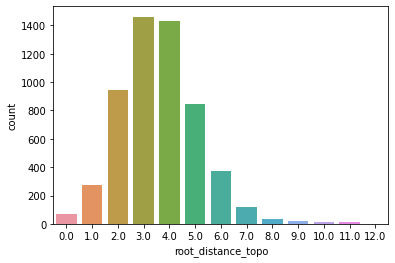

In [9]:
sns.countplot(data=df, x="root_distance_topo")
plt.show()

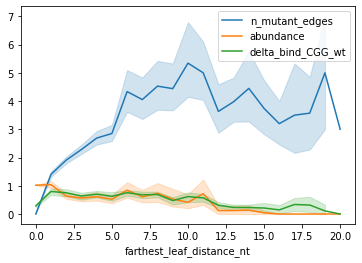

In [10]:
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="n_mutant_edges", label="n_mutant_edges")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="abundance", label="abundance")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="delta_bind_CGG_naive", label="delta_bind_CGG_wt")
# sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="polytomy_degree", label="polytomy_degree")
plt.ylabel("")
plt.show()

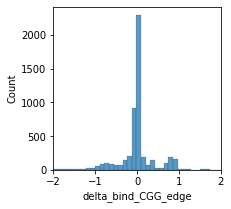

In [11]:
plt.figure(figsize=(3, 3))
sns.histplot(data=df, x="delta_bind_CGG_edge", bins=120)
plt.xlim(-2, 2)
plt.show()

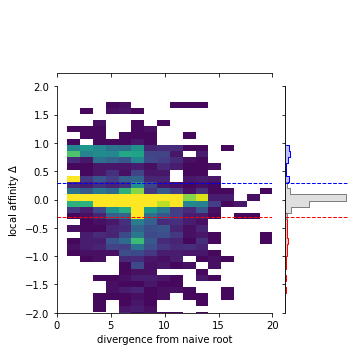

In [12]:
thresh = 0.3
df.loc[~df.delta_bind_CGG_edge.isna(), "affinity change stratum"] = "affinity neutral"
df.loc[df["delta_bind_CGG_edge"] > thresh, "affinity change stratum"] = "affinity gain"
df.loc[df["delta_bind_CGG_edge"] < -thresh, "affinity change stratum"] = "affinity loss"
palette = {"affinity loss": "red", "affinity neutral": "grey", "affinity gain": "blue"}


g = sns.JointGrid(data=df, x="root_distance_nt", y="delta_bind_CGG_edge",
                  xlim=(0, df.root_distance_nt.max()),
                  ylim=(-2, 2),
                  height=5, ratio=3)
g = g.plot_joint(sns.histplot,
                 bins=(16, 120),
                 vmax=50,
                 cmap="viridis")
sns.histplot(ax=g.ax_marg_y,
             y=df["delta_bind_CGG_edge"], hue=df["affinity change stratum"],
             bins=120,
             palette=palette,
             fill=True, element="step", linewidth=1,
             legend=False)
g.ax_marg_y.axhline(thresh, c="blue", ls="--", lw=1)
g.ax_marg_y.axhline(-thresh, c="red", ls="--", lw=1)
g.ax_joint.axhline(thresh, c="blue", ls="--", lw=1)
g.ax_joint.axhline(-thresh, c="red", ls="--", lw=1)
g.set_axis_labels("divergence from naive root", r"local affinity $\Delta$")
plt.savefig(f"{output_dir}/heatmap.pdf")
plt.show()


# g = sns.JointGrid(data=df, x="root_distance_nt", y="LBR",
#                   xlim=(0, df.root_distance_nt.max()),
#                   height=5, ratio=3)
# g = g.plot_joint(sns.histplot,
#                  bins=(16, 15),
#                  vmax=50,
#                  cmap="viridis",
#                  log_scale=(False, False))
# sns.histplot(ax=g.ax_marg_y,
#              y=df.LBR, hue=df["affinity change stratum"],
#              log_scale=False,
#              bins=15,
#              stat="probability", common_norm=False,
#              palette=palette,
#              fill=False, element="step", linewidth=1,
#              legend=False)
# g.set_axis_labels("divergence from naive root", "LBR")
# plt.show()

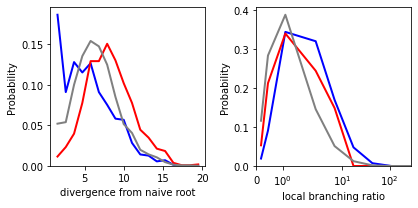

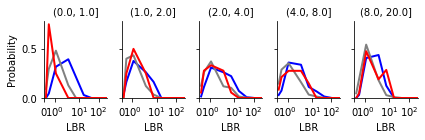

In [13]:
df["divergence stratum"] = pd.cut(df.root_distance_nt, [0, 1, 2, 4, 8, df.root_distance_nt.max()])

plt.figure(figsize=(6, 3))

plt.subplot(121)
sns.histplot(data=df, x="root_distance_nt", hue="affinity change stratum",
             bins=18,
             stat="probability", common_norm=False,
             palette=palette,
             fill=False, element="poly", linewidth=2,
             legend=False)
plt.xlabel("divergence from naive root")

plt.subplot(122)
sns.histplot(data=df, x="LBR", hue="affinity change stratum",
             bins=np.logspace(-1, np.log10(df.LBR.max()) + 1, 10),
             stat="probability", common_norm=False,
             palette=palette,
             fill=False, element="poly", linewidth=2,
             legend=False)
plt.xlabel("local branching ratio")
plt.xscale("symlog")
plt.xlim(0, None)
plt.tight_layout()
plt.savefig(f"{output_dir}/divergence-LBR.pdf")
plt.show()

g = sns.displot(data=df,
            col="divergence stratum",
            x="LBR", hue="affinity change stratum",
            hue_order=palette.keys(),
            palette=palette,
            bins=np.logspace(-1, np.log10(df.LBR.max()) + 1, 10),
            stat="probability",
            common_norm=False,
            aspect=0.6, height=2,
            fill=False, element="poly", linewidth=2,
            legend=False
           )
g.set_titles(col_template="{col_name}")
plt.xscale("symlog")
plt.xlim(0, None)
plt.savefig(f"{output_dir}/divergence-stratified-LBR.pdf")
plt.show()

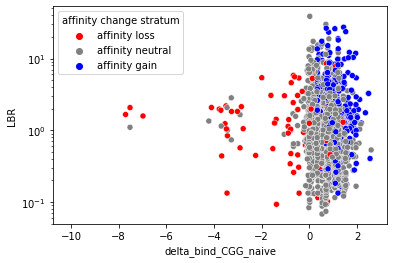

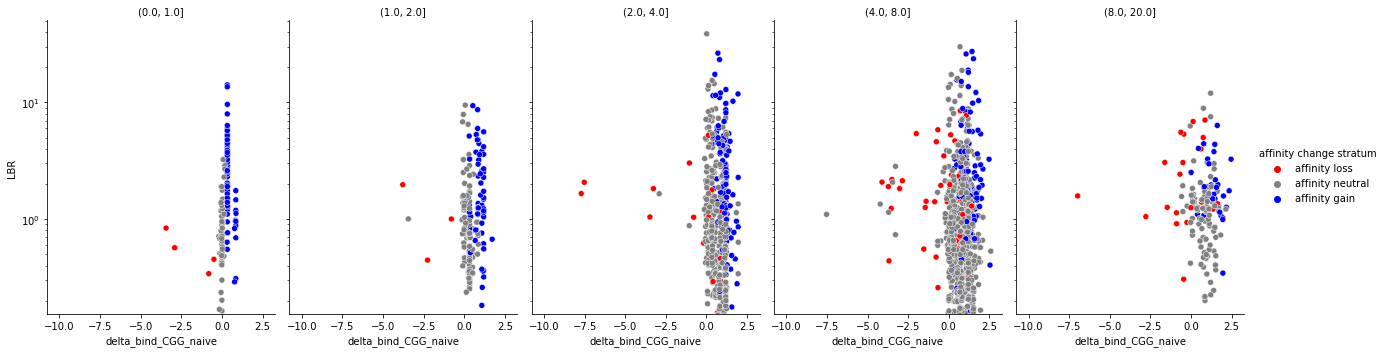

In [16]:
g = sns.scatterplot(data=df, x="delta_bind_CGG_naive", y="LBR", hue="affinity change stratum",
                palette=palette, hue_order=palette.keys())
plt.yscale("log")
# g.set_xlabels("affinity")
plt.show()

g = sns.relplot(data=df, x="delta_bind_CGG_naive", y="LBR", col="divergence stratum", hue="affinity change stratum",
                palette=palette, hue_order=palette.keys(),
           aspect=0.7, height=5,)
g.set_titles(col_template="{col_name}")
# g.axes[0,0].axvline(thresh)
plt.yscale("log")
# g.set_xlabels("affinity")
plt.show()

LBI: p=0.00
LBR: p=0.00
polytomy degree: p=0.00
LBF: p=0.00


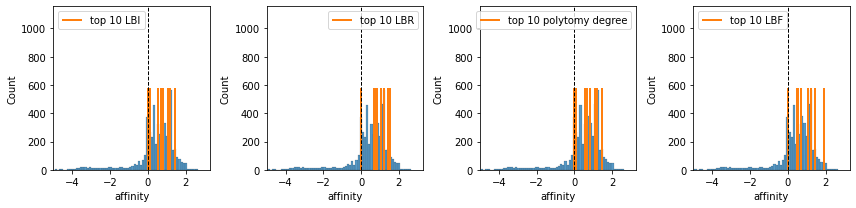

In [17]:
from scipy.stats import ttest_ind

top = 10

plt.figure(figsize=(12, 3))
plt.subplot(141)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("LBI", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.5, label=f"top {top} LBI", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'LBI: p={ttest_ind(df.LBI[df.sort_values("LBI", ascending=False).head(top).index], df.LBI[~df.index.isin(df.sort_values("LBI", ascending=False).head(top).index)]).pvalue:.2f}')

plt.subplot(142)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("LBR", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.5, label=f"top {top} LBR", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'LBR: p={ttest_ind(df.LBR[df.sort_values("LBR", ascending=False).head(top).index], df.LBR[~df.index.isin(df.sort_values("LBR", ascending=False).head(top).index)], nan_policy="omit").pvalue:.2f}')

plt.subplot(143)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("polytomy_degree", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.5, label=f"top {top} polytomy degree", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'polytomy degree: p={ttest_ind(df.polytomy_degree[df.sort_values("polytomy_degree", ascending=False).head(top).index], df.polytomy_degree[~df.index.isin(df.sort_values("polytomy_degree", ascending=False).head(top).index)]).pvalue:.2f}')

plt.subplot(144)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("LBF", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.5, label=f"top {top} LBF", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'LBF: p={ttest_ind(df.LBF[df.sort_values("LBF", ascending=False).head(top).index], df.LBF[~df.index.isin(df.sort_values("LBF", ascending=False).head(top).index)]).pvalue:.2f}')

plt.tight_layout()

plt.savefig(f"{output_dir}/top10.pdf")
plt.show()


# g = sns.displot(data=df, x="delta_bind_CGG_naive", col="divergence stratum", hue="burst",
#                 alpha=1, hue_order=[True, False],
#            aspect=0.7, height=3,)
# g.set_titles(col_template="{col_name}")
# g.axes[0,0].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,1].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,2].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,3].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,4].axvline(0, c="k", ls="--", lw=1)
# g.set_xlabels("affinity")
# plt.xlim(-2, 2)
# plt.show()

### Do high LBI events drive GC-wise affinity outcomes?

In [ ]:
early_burst_GCs = set(df.loc[(df.LBI > 10) & (df.root_distance_nt <= 2)].GC.unique())
early_burst_GCs

In [ ]:
df["early_burst_GC"] = df.GC.isin(early_burst_GCs)
df

In [ ]:
plt.figure(figsize=(15, 5))
sns.violinplot(data=df.sort_values("early_burst_GC"), x="GC", hue="early_burst_GC", y="delta_bind_CGG_naive", weights="abundance", dodge=False)
plt.axhline(0, ls="--", c="red")
plt.ylim(-5, 5)
plt.xticks(rotation=90)
plt.show()

Mutability change Vs affinity change over edges

In [ ]:
# g = sns.JointGrid(data=df, x="mutability_change", y="delta_bind_CGG_edge", ylim=(-2, 2), height=10, ratio=3)
# g = g.plot_joint(sns.histplot, bins=(30, 120), vmax=60, cmap="viridis", fill=True)
# sns.histplot(x=df["mutability_change"], bins=30, color="grey", ax=g.ax_marg_x)
# sns.histplot(y=df["delta_bind_CGG_edge"], bins=120, color="grey", ax=g.ax_marg_y)
# plt.show()

In [ ]:
# plt.figure(figsize=(4.5, 4.5))
# ax = sns.histplot(data=df, x="mutability_change", hue="affinity change stratum",
#              hue_order=palette.keys(),
#              bins=10,
#              stat="probability", common_norm=False,
#              palette=palette,
#              fill=False, element="poly", linewidth=2)

## Frequent mutations

In [ ]:
from collections import Counter

mutation_events = Counter()
mutation_prevalence = Counter()
for idx, row in df.iterrows():
    if row.aa_mutations_edge_gained:
        mutation_events.update(row.aa_mutations_edge_gained.split(";"))
    if row.abundance and row.aa_mutations:
        mutation_prevalence.update({mutation: row.abundance for mutation in row.aa_mutations.split(";")})

In [ ]:
df_mutations = pd.Series(mutation_events, name="mutation_events").to_frame().join(pd.Series(mutation_prevalence, name="mutation_prevalence"))
df_mutations.sort_values("mutation_events", ascending=False)[:20]

### Pairwise epistasis

### Is the bump still there if we remove putatively epistatic mutations?

In [ ]:
# frequent_mutations = df_mutations.sort_values("mutation_events", ascending=False).index[:100]

frequent_mutations = set(['A105(H)G', 'N108(L)K', 'A40(L)G', 'S109(L)R', 'S64(H)R','N108(L)Y','N108(L)H', 'N108(L)S'])

plt.figure(figsize=(8, 6))
sns.histplot(data=df,
             x="delta_bind_CGG_edge",
             bins=150, color="C0",
             label="all edges",
             fill=False, element="step", linewidth=2)
sns.histplot(data=df.loc[df.aa_mutations_edge_gained.map(lambda mutations: not any(mutation in frequent_mutations for mutation in mutations.split(";")))],
             x="delta_bind_CGG_edge",
             bins=150, color="C1", 
             label=f"exluding {', '.join(frequent_mutations)}",
             fill=False, element="step", linewidth=2)
plt.xlim(-2, 2)
plt.legend(loc="upper left")
plt.show()

In [ ]:
dms_df[frequent_mutations]

## Permissive selection below bursts? Stratified by root distance